In [1]:
# %%
# ----- セル1: 初期設定とモデルの読み込み -----
import torch
from transformers import AutoProcessor, AutoModel
from datasets import load_dataset
from tqdm import tqdm
import torch.nn.functional as F
import pickle # Pythonオブジェクトを保存するためのライブラリ

# デバイスの確認
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# モデル名を指定
model_name = "openai/clip-vit-base-patch32"

# モデルとプロセッサーを読み込み
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
print("✅ Model and processor loaded successfully!")

# データセットを読み込み
dataset_name = "ashraq/fashion-product-images-small"
dataset = load_dataset(dataset_name, split="train", streaming=True)
print("✅ Dataset loaded successfully!")

c:\Users\dolla\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


✅ Model and processor loaded successfully!
✅ Dataset loaded successfully!


In [2]:
# %%
# ----- セル2: 特徴量ベクトルの計算とファイル保存 -----
print("Starting image vectorization...")

all_image_features = []
all_images = []

# データセットの画像を1000件だけ処理
for example in tqdm(dataset.take(1000), total=1000):
    image = example["image"]
    if image is None:
        continue
    image = image.convert("RGB")
    
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        
    all_image_features.append(image_features.cpu()) # CPUに移動してから保存
    all_images.append(image)

# 計算したベクトルを1つのテンソルにまとめる
feature_tensor = torch.cat(all_image_features)
print(f"\n✅ Vectorized {len(all_image_features)} images.")
print("Feature tensor shape:", feature_tensor.shape)

# 計算結果をファイルに保存する
torch.save(feature_tensor, "features.pt")
with open("images.pkl", "wb") as f:
    pickle.dump(all_images, f)

print("✅ Features and images saved to files!")

Starting image vectorization...


100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


✅ Vectorized 1000 images.
Feature tensor shape: torch.Size([1000, 512])
✅ Features and images saved to files!


✅ Features and images loaded from files!
✅ Search complete!
Query image (index: 300):


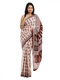

Most similar image found (index: 300):


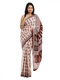

In [ ]:
# %%
# ----- セル3: 保存したファイルを読み込んで類似検索 -----

# ファイルからベクトルと画像を読み込む
feature_tensor = torch.load("features.pt").to(device)
with open("images.pkl", "rb") as f:
    all_images = pickle.load(f)
print("✅ Features and images loaded from files!")

# 検索したい画像（クエリ画像）を準備
query_index = 300
query_image = all_images[query_index]

# クエリ画像をベクトル化
inputs = processor(images=query_image, return_tensors="pt").to(device)
with torch.no_grad():
    query_features = model.get_image_features(**inputs)

# コサイン類似度を計算
similarities = F.cosine_similarity(query_features, feature_tensor)
best_match_index = torch.argmax(similarities).item()
result_image = all_images[best_match_index]
print("✅ Search complete!")

# 検索元画像と、見つかった画像を表示
print(f"Query image (index: {query_index}):")
display(query_image)

print(f"Most similar image found (index: {best_match_index}):")
display(result_image)